In [1]:
import torch
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
from tqdm import tqdm

from two_spirals_utils import SpiralClassifier
from utils.attacks import fgsm

from manifold_flow.flows import ManifoldFlow
from manifold_flow import transforms
from manifold_flow.architectures.vector_transforms import create_vector_transform

### Load pre-trained classifier model

In [2]:
classifier = SpiralClassifier(2, 2, n_inner_layers=4, width=128)
classifier.load_state_dict(torch.load("../models/spirals/classifier_two_spirals.pt"))
classifier.eval();

### Load $\mathcal{M}$-Flow model

In [3]:
# Define M-Flow model
mflow = ManifoldFlow(
    data_dim=2,
    latent_dim=1,
    inner_transform=transforms.ConditionalAffineScalarTransform(features=1),
    outer_transform=create_vector_transform(dim=2, flow_steps=16)
)

mflow.load_state_dict(torch.load("../models/spirals/spiral_mflow_A.pt"))
mflow.eval();

### Load "Two Spirals" dataset

In [4]:
# Load the "Two Spirals" dataset from disk
loaded_dataset = torch.load("../data/two_spirals/spiral_dataset_20k.pt")

# Extract X and Y from the loaded dataset
X_loaded = loaded_dataset["X"]
Y_loaded = loaded_dataset["Y"]

dataset = TensorDataset(X_loaded, Y_loaded)

### Compute relative frequency of cases A, B, C, D

For each in a range of `n_epsilons` perturbation magnitude values $\epsilon,$ we perform an FGSM attack on each the `n_samples` data points and use our $\mathcal{M}$-Flow defense against it, then record which of the four cases occurs:

- **(A)** Successful attack & successful defense
- **(B)** Failed attack & successful defense
- **(C)** Successful attack & failed defense
- **(D)** Failed attack & failed defense

In [5]:
n_samples  = 20_000
n_epsilons = 100
results    = torch.zeros(n_epsilons, 4)
epsilons   = torch.linspace(0., 0.3, n_epsilons)

for idx_eps, eps in enumerate(epsilons):
    for idx_sample in tqdm(range(n_samples)):
        x = dataset.tensors[0][[idx_sample]]
        y = dataset.tensors[1][[idx_sample]].item()

        # Generate adversarial sample
        x_adv = fgsm(classifier, x=x, label=int(y), eps=eps.item(), targeted=False).detach()

        # Transform adversarial attack sample into latent space
        x_latent = mflow.encode(x_adv)

        # Project adversarial attack sample onto manifold
        x_proj   = mflow.decode(x_latent).detach()

        with torch.no_grad():
            pred_adv = classifier(x_adv)
            pred_adv = pred_adv.argmax(axis=1).item()

            pred_def = classifier(x_proj)
            pred_def = pred_def.argmax(axis=1).item()

        att_success = pred_adv != y
        def_success = pred_def == y

        if att_success and def_success:
            # Case (A)
            results[idx_eps, 0] += 1
        elif def_success:
            # Case (B)
            results[idx_eps, 1] += 1
        elif att_success:
            # Case (C)
            results[idx_eps, 2] += 1
        else:
            # Case (D)
            results[idx_eps, 3] += 1

torch.save(results, "results.pt")

100%|██████████| 20000/20000 [04:14<00:00, 78.45it/s]


In [98]:
results = torch.load("../data/experimental_results/spiral_defense_cases_frequency/results.pt")

# Normalise all cases so we get probabilities that sum to 1
results /= results.sum(dim=1)[:,None]

A, B, C, D = results.T

### Visualise the Relative Frequencies

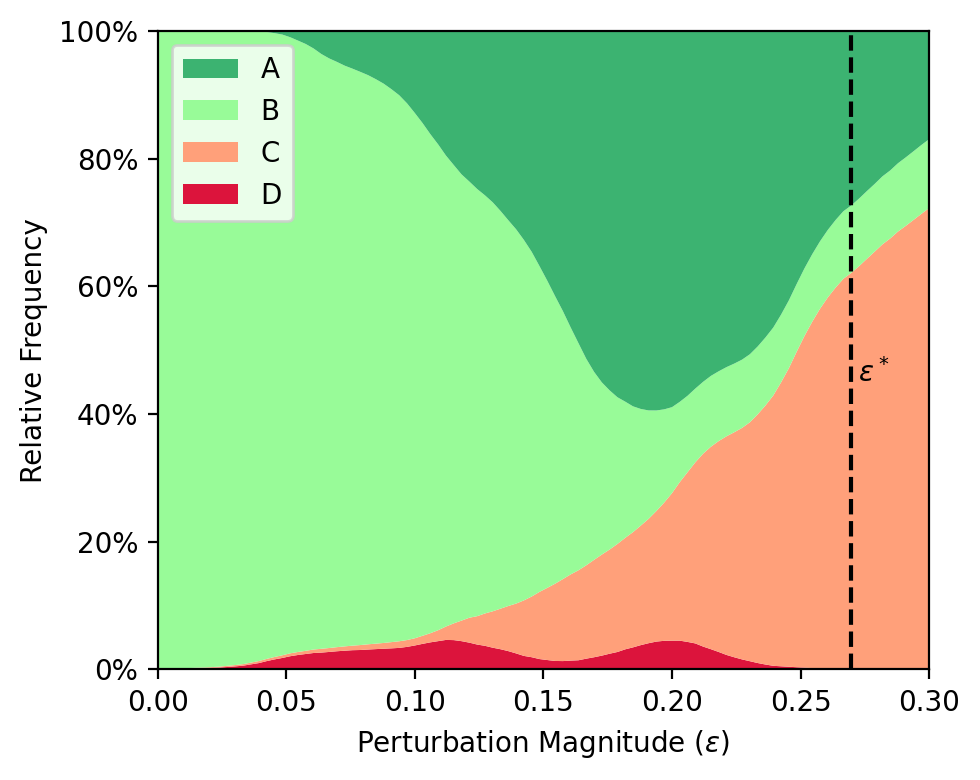

In [99]:
plt.figure(figsize=(5, 4), dpi=200)
plt.stackplot(
    epsilons, D, C, B, A,
    labels=["D", "C", "B", "A"],
    colors=["crimson", "lightsalmon", "palegreen", "mediumseagreen"]
)

# plt.title("Relative Frequency of Adversarial Defense Cases on 'Two Spirals' Dataset")
plt.xlabel(r"Perturbation Magnitude ($\epsilon$)")
plt.ylabel("Relative Frequency")
plt.legend(reverse=True, loc="upper left")
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
plt.vlines([best_eps], 0, 1, colors="black", ls="--")
plt.text(best_eps*1.01, 0.45, r"$\epsilon^*$")
plt.margins(0)

plt.tight_layout()
# plt.savefig(f"../figures/report/spiral_cases_freqs.pdf")

### Analyse results numerically

In [100]:
# Cases A & C are those with successful attacks
cases_AC = results[:, [0, 2]].sum(dim=1)

# Cases B & D are those with failed attacks
cases_BD = results[:, [1, 3]].sum(dim=1)

cases_AC_BD = torch.row_stack([cases_AC, cases_BD])
cases_AC_BD /= cases_AC_BD.sum(dim=0)

# Find eps with highest percentage of succeeded attacks
n_epsilons = 100
epsilons   = torch.linspace(0., 0.3, n_epsilons)
idx_eps    = cases_AC_BD[0].argmax()
best_eps   = epsilons[idx_eps].item()

print(f"Most effective eps:                             {best_eps:.4f}")

print(f"Ratio of successful attacks with this eps:      {cases_AC_BD[0][idx_eps]*100:.2f}%")

# Find what percentage of those attacks were prevented
percent_of_successful_attacks_prevented = (results[idx_eps, 0] / cases_AC[idx_eps]).item()

print(f"Ratio of successful attacks defended against:   {percent_of_successful_attacks_prevented*100:.2f}%")

Most effective eps:                             0.2697
Ratio of successful attacks with this eps:      89.36%
Ratio of successful attacks defended against:   30.59%
